In [1]:
import gc
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import geopandas as gpd
from shapely.geometry import Point

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, mean_absolute_error, mean_squared_error, make_scorer, confusion_matrix, recall_score, roc_auc_score
from sklearn import preprocessing
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = 'all_v2.csv'

REGION_ID = 2661  # City of Saint Petersburg

MIN_AREA = 15  # Outlier range for floor area
MAX_AREA = 300

MIN_KITCHEN = 3  # Outlier range for kitchen area
MAX_KITCHEN = 70

MIN_PRICE = 1_000_000  # Outlier range for price
MAX_PRICE = 100_00 0_000

SEED = 15
N_FOLDS = 5

In [3]:
def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

def select_region(df: pd.DataFrame) -> pd.DataFrame:
    """Function selects the listings belonging to a specified region.
    :param df: Original DataFrame with all listings
    :return: Filtered DataFrame
    """
    df = df[df['region'] == REGION_ID]
    df.drop('region', axis=1, inplace=True)
    print(f'Selected {len(df)} samples in region {REGION_ID}.')
    return df


def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # Replace "date" with numeric features for year and month.
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df.drop('date', axis=1, inplace=True)
    # Apartment floor in relation to total number of floors.
    df['level_to_levels'] = df['level'] / df['levels']
    # Average size of room in the apartment.
    df['area_to_rooms'] = (df['area'] / df['rooms']).abs()
    # Fix division by zero.
    df.loc[df['area_to_rooms'] == np.inf, 'area_to_rooms'] = \
        df.loc[df['area_to_rooms'] == np.inf, 'area']
    return df

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Function removes excess columns and enforces
    correct data types.
    :param df: Original DataFrame
    :return: Updated DataFrame
    """
    df.drop('time', axis=1, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    # Column actually contains -1 and -2 values presumably for studio apartments.
    df['rooms'] = df['rooms'].apply(lambda x: 0 if x < 0 else x)
    df['price'] = df['price'].abs()  # Fix negative values
    # Drop price and area outliers.
    df = df[(df['area'] <= MAX_AREA) & (df['area'] >= MIN_AREA)]
    df = df[(df['price'] <= MAX_PRICE) & (df['price'] >= MIN_PRICE)]
    # Fix kitchen area outliers.
    # At first, replace all outliers with 0.
    df.loc[(df['kitchen_area'] >= MAX_KITCHEN) | (df['kitchen_area'] <= MIN_KITCHEN), 'kitchen_area'] = 0
    # Then calculate kitchen area based on the floor area, except for studios.
    erea_mean, kitchen_mean = df[['area', 'kitchen_area']].quantile(0.5)
    kitchen_share = kitchen_mean / erea_mean
    df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'kitchen_area'] = \
        df.loc[(df['kitchen_area'] == 0) & (df['rooms'] != 0), 'area'] * kitchen_share

    return df

def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
def get_overpass_gdf(query_string: str):
    """Meke geodataframe from Overpass API
    :param query_string: Ovepass API query
    :return: Geodataframe
    """
    # Retrieve URL contents
    r = requests.get(query_string)

    # Make dataframe
    df = pd.DataFrame(r.json()['elements'])

    # Make geodataframe
    df['geometry'] = [Point(xy) for xy in zip(df.lon, df.lat)]
    df = gpd.GeoDataFrame(df, geometry='geometry')

    return df

In [4]:
set_display()

In [5]:
data = pd.read_csv(PATH)
print(f'Data shape: {data.shape}')
data.head()

Data shape: (5477006, 13)


,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.8058,30.3761,2661,1,8,10,3,82.6000,10.8000,1
1,8650000,2018-02-27,12:04:54,55.6838,37.2974,81,3,5,24,2,69.1000,12.0000,1
2,4000000,2018-02-28,15:44:00,56.2953,44.0616,2871,1,5,9,3,66.0000,10.0000,1
3,1850000,2018-03-01,11:24:52,44.9961,39.0748,2843,4,12,16,2,38.0000,5.0000,11
4,5450000,2018-03-01,17:42:43,55.9188,37.9846,81,3,13,14,2,60.0000,10.0000,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


In [7]:
data.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000,5477006.0000
mean,4422029.0229,54.0383,53.2443,4307.1409,1.9490,6.2145,11.3989,1.7262,53.9182,10.6284,3.9454
std,21507519.1548,4.6228,20.7476,3308.0502,1.0385,4.9574,6.5357,1.0821,33.3529,9.7924,4.5584
min,-2144967296.0000,41.4591,19.8902,3.0000,0.0000,1.0000,1.0000,-2.0000,0.0700,0.0100,1.0000
25%,1950000.0000,53.3777,37.7779,2661.0000,1.0000,2.0000,5.0000,1.0000,38.0000,7.0000,1.0000
50%,2990000.0000,55.1714,43.0677,2922.0000,2.0000,5.0000,10.0000,2.0000,48.0200,9.7000,1.0000
75%,4802000.0000,56.2261,65.6489,6171.0000,3.0000,9.0000,16.0000,2.0000,63.1300,12.7000,11.0000
max,2147483647.0000,71.9804,162.5361,61888.0000,5.0000,39.0000,39.0000,10.0000,7856.0000,9999.0000,11.0000


In [8]:
data = data.pipe(clean_data)
data.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,59.8058,30.3761,2661,1,8,10,3,82.6000,10.8000,1
1,8650000,2018-02-27,55.6838,37.2974,81,3,5,24,2,69.1000,12.0000,1
2,4000000,2018-02-28,56.2953,44.0616,2871,1,5,9,3,66.0000,10.0000,1
3,1850000,2018-03-01,44.9961,39.0748,2843,4,12,16,2,38.0000,5.0000,11
4,5450000,2018-03-01,55.9188,37.9846,81,3,13,14,2,60.0000,10.0000,1


In [9]:
data = data.pipe(select_region)
data = data.pipe(add_features)
data["id"] = data.index + 1
data.head()

Selected 459737 samples in region 2661.


,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms,id
0,6050000,59.8058,30.3761,1,8,10,3,82.6000,10.8000,1,2018,2,0.8000,27.5333,1
7,3600000,59.8755,30.3955,1,2,5,1,31.1000,6.0000,1,2018,3,0.4000,31.1000,8
36,3200000,59.8275,30.2018,1,7,9,1,31.0000,7.0000,1,2018,4,0.7778,31.0000,37
47,6500000,59.9883,29.7869,3,3,3,3,89.0000,10.0000,1,2018,4,1.0000,29.6667,48
54,6300000,59.9116,30.2846,3,5,5,2,99.9000,14.5000,1,2018,4,1.0000,49.9500,55


<AxesSubplot:>

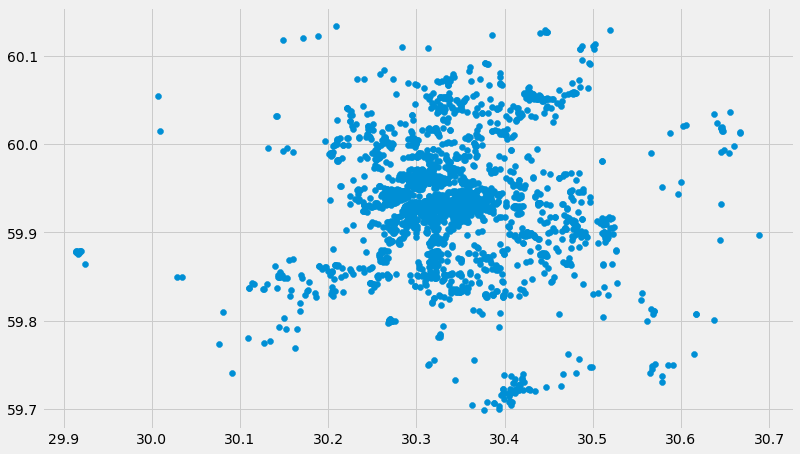

In [10]:
url = 'https://maps.mail.ru/osm/tools/overpass/api/interpreter?data='
query = '[out:json];'\
        'nwr["addr:street"="Лиговский проспект"]["addr:housenumber"="101"];'\
        'node[amenity=cafe](around:25000);'\
        'out geom;'

cafes_gdf = get_overpass_gdf(url+query)
cafes_gdf.plot()

<AxesSubplot:>

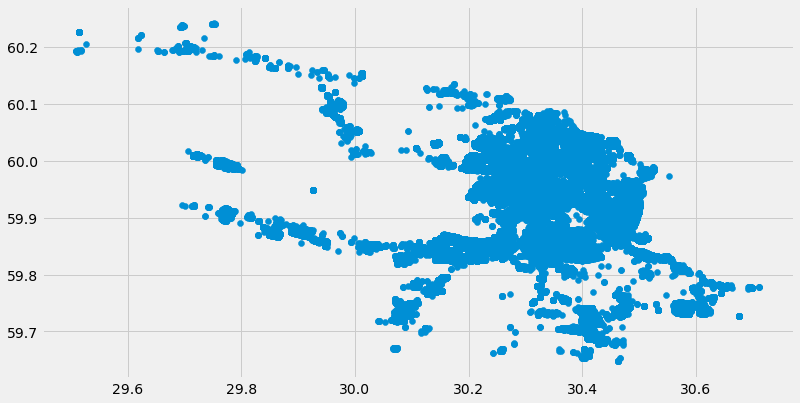

In [11]:
data['geometry'] = [Point(xy) for xy in zip(data.geo_lon, data.geo_lat)]
data_gdf = gpd.GeoDataFrame(data, geometry='geometry')
data_gdf.plot()

In [30]:
def add_cafee_feature(radius):
    data_gdf['cafes_' + str(radius)] = 0
    list_arrays = [ np.array((geom.xy[0][0], geom.xy[1][0])) for geom in cafes_gdf["geometry"] ]
    list_tuples = [tuple(x) for x in list_arrays]
    points_array = np.array(list_tuples)
    max_distance = radius
    for idx, geometry in data_gdf['geometry'].iteritems():
        current_flat_position = np.array([geometry.x, geometry.y])
        distance_array = np.sqrt(np.sum((points_array - current_flat_position) ** 2, 1))
        near_points = points_array[distance_array < max_distance]
        cafe_number = len(near_points)
        data_gdf['cafes_' + str(radius)].at[idx] = cafe_number
        
cafe_radius_range = [0.002, 0.005, 0.08, 0.012]
for radius in cafe_radius_range:
    add_cafee_feature(radius)
data_gdf.to_csv("data_gdf_cafes.csv")

In [56]:
data_gdf = pd.read_csv("data_gdf_cafes.csv")

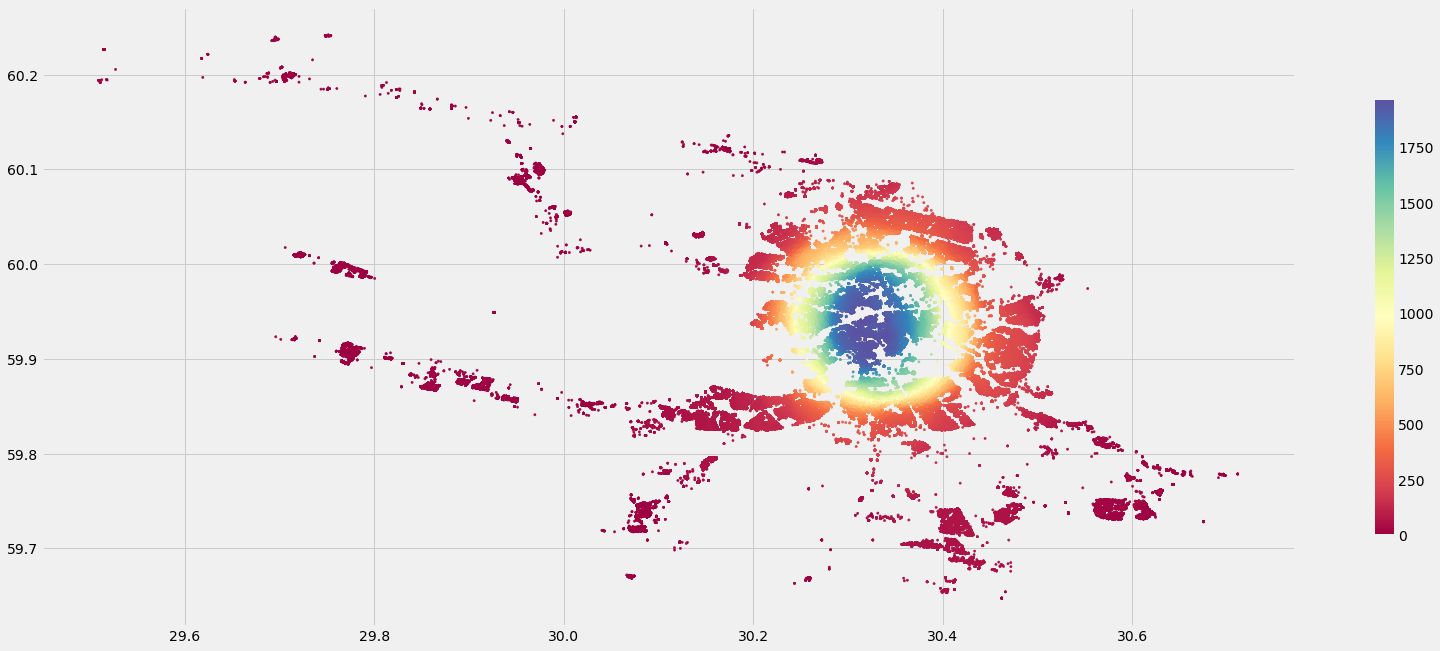

In [57]:
#data_gdf.plot(markersize=200, color="blue", marker="o", column='cafes_500')
geo_df = data_gdf
#geo_df['price_log'] = np.log(geo_df['price'])fig, ax = plt.subplots(figsize = (10,10))

fig, ax = plt.subplots(figsize = (25,25))
#kings_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = 'cafes_0.08', ax=ax, cmap = 'Spectral',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 5)
#ax.set_title('Kings County Price Heatmap')
plt.savefig('Heat Map')

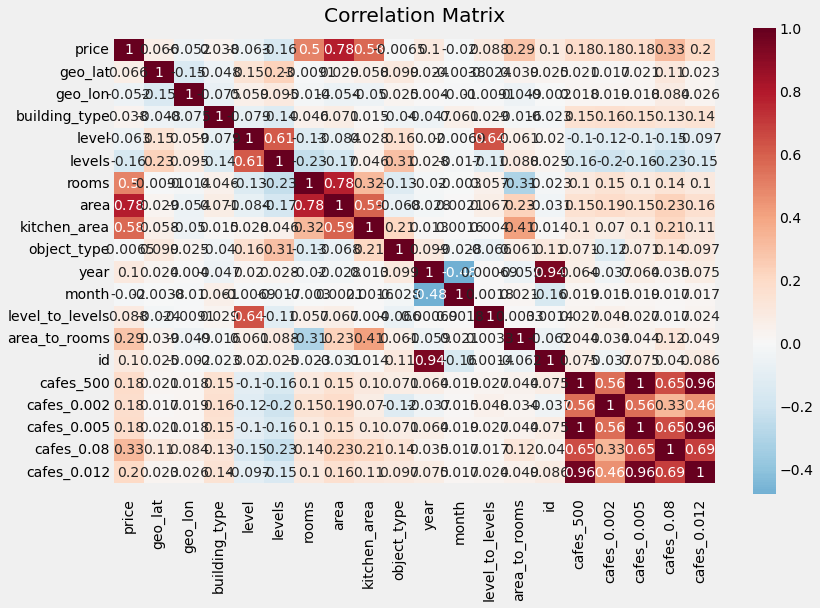

In [33]:
correlation = data_gdf.corr()
ax = sns.heatmap(correlation, annot=True, center=0, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()

In [273]:
FEATURES = ['price', 'geo_lat', 'geo_lon', 'building_type', 'level', 'levels',
            'area', 'kitchen_area', 'object_type', 'year', 'month',
            'level_to_levels', 'area_to_rooms', 'cafes_0.012', 'cafes_0.08']

data_x = data_gdf[FEATURES]

# data_x['geo_lat'] = (data_x['geo_lat'] - 59)*1000
# data_x['geo_lon'] = (data_x['geo_lon'] - 29)*1000
# data_x['geo_lat'] = data_x['geo_lat'].astype('int64') 
# data_x['geo_lon'] = data_x['geo_lon'].astype('int64')

data_x = data_x.drop_duplicates(subset=['geo_lat','geo_lon', 'level', 'area'], keep="last")


X = data_x.drop('price', axis = 1)
y = data_x['price']
data_x.shape

(331326, 15)

In [276]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.25, random_state=23)

In [277]:
%%time
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_holdout, y_holdout, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l1'},
    'max_depth':11,
    'num_leaves': 150,
    'learning_rate': 0.25,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'n_estimators':1000,
    'bagging_freq': 2,
    'verbose': -1
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                verbose_eval=False,
                early_stopping_rounds=30) #categorical_feature=['building_type']
y_predicted = gbm.predict(X_holdout, num_iteration=gbm.best_iteration)
mean_absolute_error(y_holdout, y_predicted)

Wall time: 4.5 s


875505.2859826321

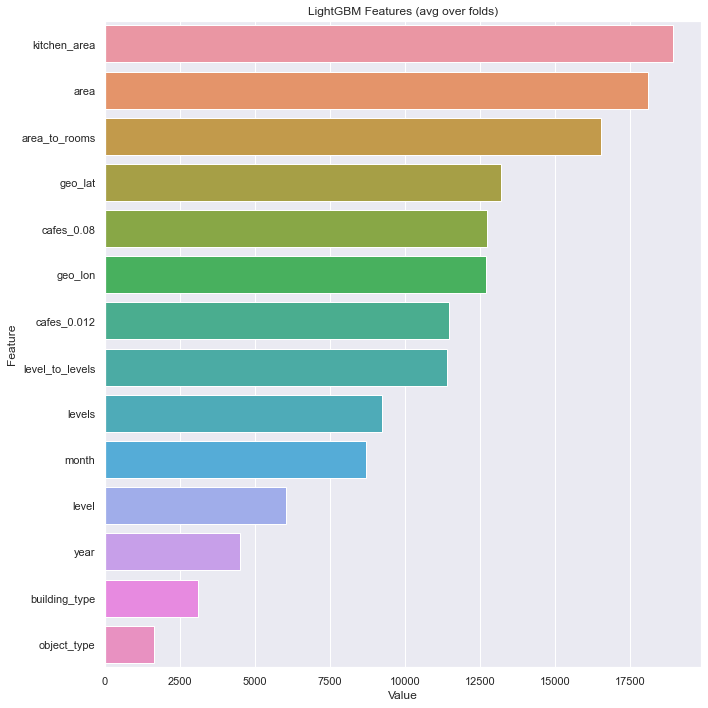

In [278]:
# Display feature importance.
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(gbm, X , num = 20):
    feature_imp = pd.DataFrame({'Value':gbm.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(gbm, X, num = 40)

Wall time: 1.17 s


<AxesSubplot:>

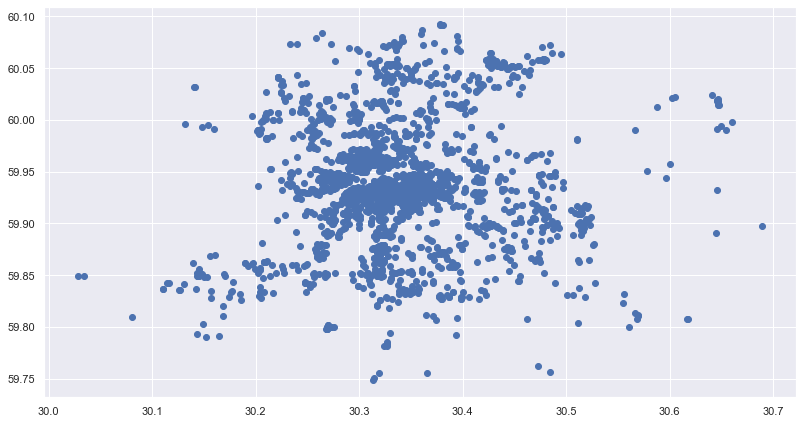

In [135]:
%%time
import overpy
import requests
import http.client
import re
import time
from shapely.geometry import shape
import geopandas as gpd
import json
from typing import Dict, Text, Any, List, Union, Optional

query = '[out:json];'\
        'nwr["addr:street"="Лиговский проспект"]["addr:housenumber"="101"];'\
        'node[amenity=cafe](around:20000);'\
        'convert item ::=::,::geom=geom(),_osm_type=type();'\
        'out geom;'

try:
    res = requests.get(f'https://maps.mail.ru/osm/tools/overpass/api/interpreter?data=' + query)
    data = res.json()
except Exception as e:
    print("Exception:", e)
    pass

objects = str(data['elements'])
with open('your_file.txt', 'w', encoding="utf-8") as f:
    f.write(objects)
    
def elem_to_feature(elem):
    return {
        "geometry": elem["geometry"],
        "properties": elem["tags"],
    }

features = [elem_to_feature(elem) for elem in data["elements"]]
gdf = gpd.GeoDataFrame.from_features(features)
gdf.plot()